## https://github.com/CornellNLP/ConvoKit

There are conversational text data, we download some of them.

In [1]:
import io
import os
import re
import spacy
import random
import json
import convokit
import math
import nltk
import kenlm
import pprint
import string
import numpy as np
from tqdm import tqdm
from nltk import ngrams
from convokit import Corpus, download
from spacy.tokenizer import Tokenizer
from collections import defaultdict
from itertools import product
from nltk.util import ngrams
from nltk.lm import NgramCounter
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt

In [2]:
# load the dataset, you can use a small dataset ("wikipedia-politeness-corpus", it is about 600kb) to do a fast test.
corpus_name = "reddit-coarse-discourse-corpus"
subreddit_corpus = Corpus(download(corpus_name), disable_type_check=True)

Dataset already exists at /Users/baojianzhou/.convokit/saved-corpora/reddit-coarse-discourse-corpus


In [3]:
def clean_text(text):
    doc = nlp(text)
    cleaned_tokens = [token.text if token.is_alpha or token.is_punct or token.is_digit else ' ' for token in doc]
    cleaned_text = " ".join(cleaned_tokens)
    cleaned_text = re.sub(r'[^\w\s.,!?;]', ' ', cleaned_text)
    cleaned_text = " ".join(cleaned_text.split())
    return cleaned_text.strip()

In [4]:
train_file = f'convokit-{corpus_name}-train.txt'
valid_file = f'convokit-{corpus_name}-valid.txt'
test_file = f'convokit-{corpus_name}-test.txt'
vocab_file = f'convokit-{corpus_name}-vocab.json'

random.seed(17)
vocab = defaultdict(int)
nlp = spacy.load("en_core_web_sm")
num_tokens = 0
num_sents = 0
train_prec = 0.98
valid_prec = 0.01
test_prec = 0.01

with open(train_file, 'w') as train_out, open(valid_file, 'w') as valid_out, open(test_file, 'w') as test_out:
    print('preprocessing: ', corpus_name)
    for ind, utt in enumerate(subreddit_corpus.iter_utterances()):
        raw_text = re.sub(r'http[s]?://\S+|www\.\S+', '', utt.text)  # Remove URLs
        raw_text = re.sub(r'[\n\r]+', ' ', raw_text)  # Remove newline characters and replace them with a space
        raw_text = re.sub(r'[^\w\s\.,!?;:(){}\'"-]', '', raw_text)  # Remove non-alphanumeric characters except punctuation
        if len(raw_text) == 0:
            continue
        doc = nlp(raw_text.lower())
        for sent in doc.sents:
            tokens = [token.text for token in sent]
            num_tokens += len(tokens)
            if len(tokens) <= 1:
                continue # ignore a single token sentence
            num_sents += 1
            line = clean_text(sent.text)
            line = line.strip()
            for item in line.split(' '):
                vocab[item] += 1
            if len(line) <= 0:
                continue
            
            # Randomly assign the sentence to train, valid, or test based on probabilities
            rand = random.random()  # Generate a random number between 0 and 1
            if rand <= train_prec:
                # 98% probability for train
                train_out.write(line + '\n')
            elif rand <= train_prec + valid_prec:
                # 1% probability for valid
                valid_out.write(line + '\n')
            else:
                # 1% probability for test
                test_out.write(line + '\n')
        if ind % 2000 == 0: # sampling some output to verify
            print(ind, len(vocab), num_sents, num_tokens, line)
print(f"vocab size: {len(vocab)}, num_sents: {num_sents}, num_tokens: {num_tokens}")
sorted_vocab = sorted(vocab.items(), key=lambda item: item[1], reverse=True)
print(sorted_vocab[:5])
with open(vocab_file, "w") as vocab_f:
    for word, count in sorted_vocab:
        json.dump({word:count}, vocab_f)
        vocab_f.write('\n')

preprocessing:  reddit-coarse-discourse-corpus
0 248 28 503 it swept me along with its quirky and interesting characters to a climax that maybe i should have seen coming . 810
2000 8994 6383 103570 you know a country was really trying for world domination when its harder to the pick one of the countries it has had a military conflict with .
4000 12134 10751 164991 nothing like a woman who lies there like a corpse ... bring on the woman who can teach you things .
6000 14180 14537 215201 please contact the moderators of this if you have any questions or concerns .
8000 16872 19661 293056 he a complete and utter loser going nowhere with his life and i almost think someone should warn his new roommatelandlord what a pig he can be .
10000 20034 26097 396681 opus eponymous has some of their best songwriting , imo
12000 23058 32162 500288 yes , there was a thread about it this week , and atheists were disagreeing on whether weak atheism is a valid form of atheism .
14000 25635 38309 606870 th

In [5]:
# the following code is runnable in Linux and Mac OS
!/Users/baojianzhou/git/kenlm/build/bin/lmplz -o 2 < convokit-reddit-coarse-discourse-corpus-train.txt > convokit-reddit-coarse-discourse-corpus-2-gram.arpa
!/Users/baojianzhou/git/kenlm/build/bin/lmplz -o 3 < convokit-reddit-coarse-discourse-corpus-train.txt > convokit-reddit-coarse-discourse-corpus-3-gram.arpa
!/Users/baojianzhou/git/kenlm/build/bin/lmplz -o 4 < convokit-reddit-coarse-discourse-corpus-train.txt > convokit-reddit-coarse-discourse-corpus-4-gram.arpa
!/Users/baojianzhou/git/kenlm/build/bin/lmplz -o 5 < convokit-reddit-coarse-discourse-corpus-train.txt > convokit-reddit-coarse-discourse-corpus-5-gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading stdin
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 5374586 types 92241
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:1106892 2:15460774912
Statistics:
1 92241 D1=0.659024 D2=0.994846 D3+=1.26749
2 1202724 D1=0.739456 D2=1.10753 D3+=1.38661
Memory estimate for binary LM:
type       kB
probing 23483 assuming -p 1.5
probing 23844 assuming -r models -p 1.5
trie     9209 without quantization
trie     5833 assuming -q 8 -b 8 quantization 
trie     9209 assuming -a 22 array pointer compression
trie     5833 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:1106892 2:19243584
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90--

In [6]:
def calculate_perplexity(test_sents, model):
    tokens = 0
    sum_log10_prob = 0.
    for sent in test_sents:
        log10_prob = model.score(sent, bos=True, eos=True)
        tokens += len(sent.split())  + 1 # 1 means </s>
        sum_log10_prob += log10_prob
    # Calculate the perplexity: 10 ** (-log10_prob / N)
    perplexity = 10.0 ** (-sum_log10_prob/tokens)
    return perplexity

In [7]:
bigram_model = kenlm.Model('convokit-reddit-coarse-discourse-corpus-2-gram.arpa')
print(bigram_model.score('this is a sentence .', bos = True, eos = True))

-8.047130584716797


Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/Library/Mobile Documents/com~apple~CloudDocs/fudan/2025/nlp-25-fall/lecture-02-LMs/convokit-reddit-coarse-discourse-corpus-2-gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [8]:
gram_2_model = kenlm.Model('convokit-reddit-coarse-discourse-corpus-2-gram.arpa')
gram_3_model = kenlm.Model('convokit-reddit-coarse-discourse-corpus-3-gram.arpa')
gram_4_model = kenlm.Model('convokit-reddit-coarse-discourse-corpus-4-gram.arpa')
gram_5_model = kenlm.Model('convokit-reddit-coarse-discourse-corpus-5-gram.arpa')

Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/Library/Mobile Documents/com~apple~CloudDocs/fudan/2025/nlp-25-fall/lecture-02-LMs/convokit-reddit-coarse-discourse-corpus-2-gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/Library/Mobile Documents/com~apple~CloudDocs/fudan/2025/nlp-25-fall/lecture-02-LMs/convokit-reddit-coarse-discourse-corpus-3-gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/Library/Mobile Documents/com~apple~CloudDocs/fudan/2025/nlp-25-fall/lec

In [9]:
# Read the sentences from the convokit-test.txt file
perplexity = []
with open('convokit-reddit-coarse-discourse-corpus-test.txt', 'r') as f:
    test_sents = f.readlines()
model_names = ['2-gram', '3-gram', '4-gram', '5-gram']
for model, model_name in zip([gram_2_model, gram_3_model, gram_4_model, gram_5_model], model_names):
    print(model_name, calculate_perplexity(test_sents, model))
    perplexity.append(calculate_perplexity(test_sents, model))

2-gram 206.1087241802966
3-gram 164.59703486989238
4-gram 157.9715974327806
5-gram 156.76689020884245


Text(0, 0.5, 'perplexity')

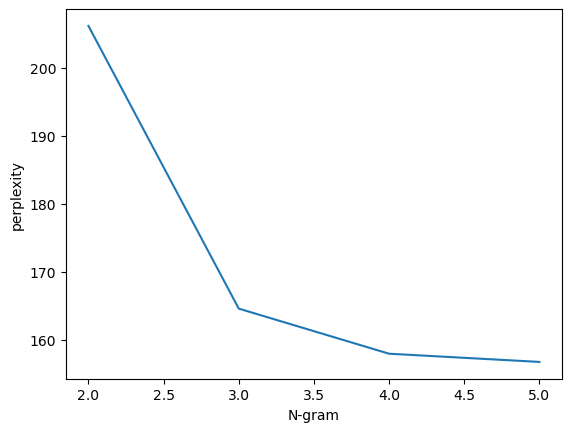

In [10]:
plt.plot([2, 3, 4, 5],perplexity)
plt.xlabel('N-gram')
plt.ylabel('perplexity')

In [47]:
def ngram_generate(model, vocab, prompt, rand_seed, k, max_words):
    random.seed(rand_seed)
    sentence = ''
    state_in, state_out = kenlm.State(), kenlm.State()
    total_score = 0.0
    model.BeginSentenceWrite(state_in)
    selected_next_word = prompt
    count = 0
    while count < max_words:
        sentence += ' ' + selected_next_word
        sentence = sentence.strip()
        total_score += model.BaseScore(state_in, word, state_out)
        candidates = list((model.score(sentence + ' ' + next_word), next_word) for next_word in vocab)
        top_words = sorted(candidates, key=lambda item: item[0], reverse=True)
        selected_next_word = top_words[random.randint(0, k)][1]
        state_in, state_out = state_out, state_in
        count += 1
    return sentence

In [48]:
vocab = set()
vocab_path = 'convokit-reddit-coarse-discourse-corpus-vocab.json'
for line in open(vocab_path):
    word_dict = json.loads(line)
    for word, count in word_dict.items():
        vocab.add(word)

In [49]:
for i in range(3):
    for n, model in zip([2,3,4,5], [gram_2_model, gram_3_model, gram_4_model, gram_5_model]):
        sentence = ngram_generate(model, vocab, "this is", rand_seed=i*4 + n, k=50, max_words=20)
        print(f'{n}-gram: ', sentence)
    print('-'*40)

2-gram:  this is ! .. haha okay to sleep like crazy haha and .... bitch ! now ....... offline lol 30 goals
3-gram:  this is my excuse that way now is not it all good friends . nbsp xd the time though as that
4-gram:  this is for free time also welcome d .. ! ... ... alrighty _ specifics man ? pics d and so
5-gram:  this is obviously ; a .. the back yet either in a specific one summer ! thanks ... here for
----------------------------------------
2-gram:  this is fun haha .. or tomorrow at ? .... today about something called smod yet unmistaken game today
3-gram:  this is fine though the janna ! ... wow time consuming loads haha dang ! ; ʖ 3 ... ..
4-gram:  this is it expensive spells , ac again ? ; 3 times over christmas one class players there xd so
5-gram:  this is 100 on twitter too .. , iirc . too risky here to me today lol retard them haha
----------------------------------------
2-gram:  this is also ? hahahahaha today actually . , one more ; o w ? d be wrong ... now or
3-gram:  